# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is the csv

In [526]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np

## 02 - Load Data and Plot Time Series
Let's start by loading the time series of the challenge and plot the time series

In [527]:
df = pd.read_csv('data/monthly_champagne_sales.csv')
df.describe()

,"Month,""Sales"""
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [528]:
df.head()

,"Month,""Sales"""
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946


In [529]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 1964-01 to 1972-09
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Month,"Sales"  105 non-null    int64
dtypes: int64(1)
memory usage: 1.6+ KB


👉 Convert dataframe with datetime objects as index to make it look like this
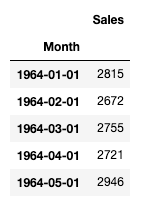

In [530]:
df = df.rename(columns={'Month,"Sales"': "sales"})
df.head()

,sales
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946


In [531]:
df.index = pd.to_datetime(df.index)
df.head()

,sales
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [532]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   105 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


In [533]:
df.index.names = ['Month']
df.head()

,sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

<Axes: xlabel='Month'>

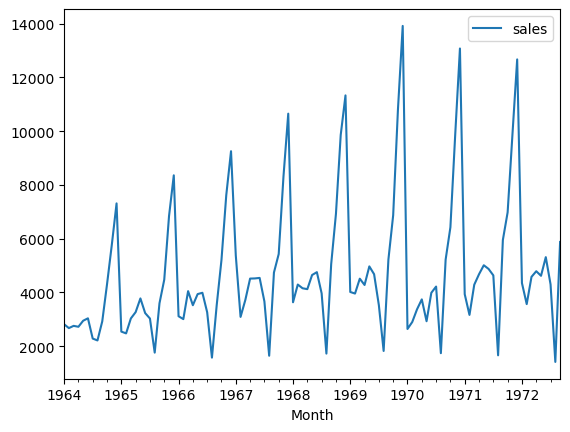

In [534]:
df.plot()

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

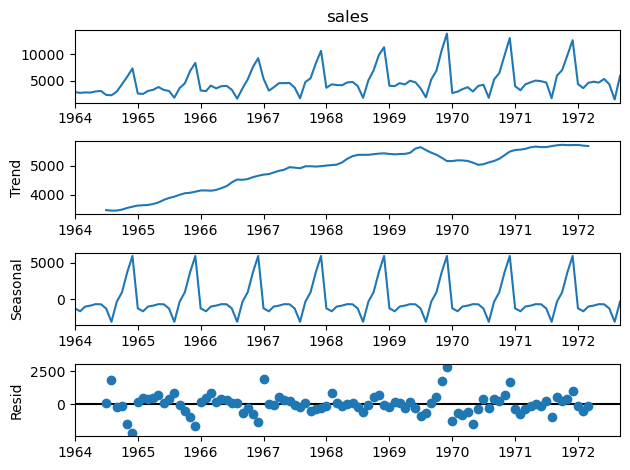

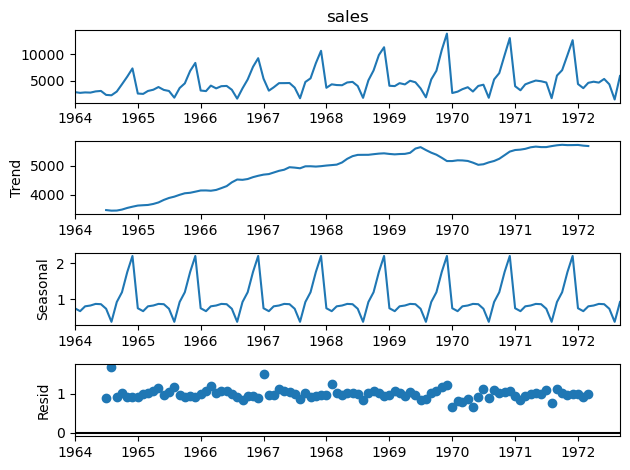

In [535]:
seasonal_decompose(df.sales, model='additive').plot();
seasonal_decompose(df.sales, model='multiplicative').plot();

👉 De-seasonalize this time serie using the decomposition of your choice

<Axes: xlabel='Month'>

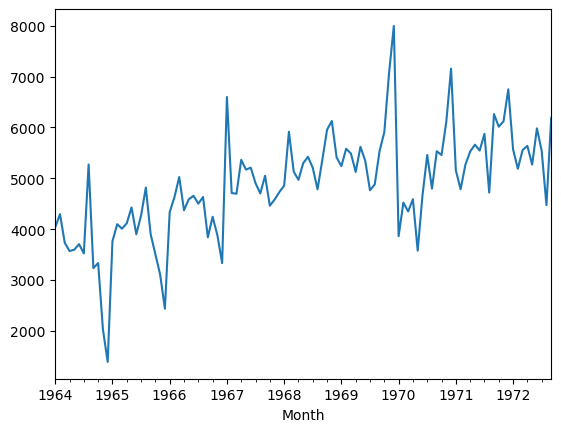

In [536]:
decompose_additive = seasonal_decompose(df.sales, model='additive')
sales_decompose =df.sales - decompose_additive.seasonal
sales_decompose.plot()

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [537]:
df_train = df[:'1969-12-01']
df_train

,sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1969-08-01,1821
1969-09-01,5222
1969-10-01,6872


In [538]:
df_test = df['1970':]
df_test

,sales
Month,
1970-01-01,2639
1970-02-01,2899
1970-03-01,3370
1970-04-01,3740
1970-05-01,2927
1970-06-01,3986
1970-07-01,4217
1970-08-01,1738
1970-09-01,5221


## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [539]:
adfuller(df.sales)[1]

0.3639157716602437

The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

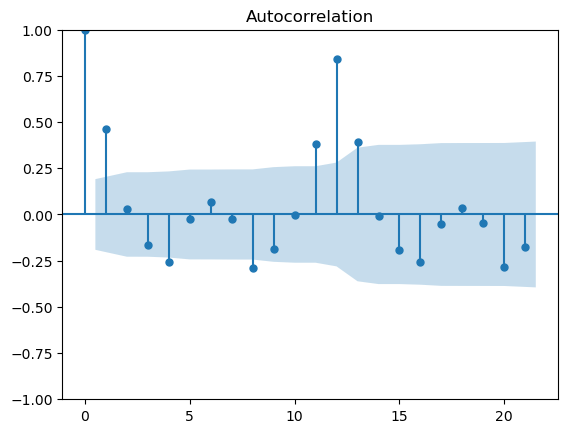

In [540]:
plot_acf(df.sales);

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

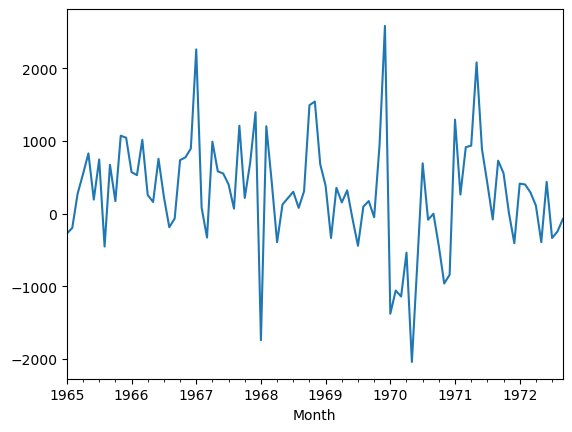

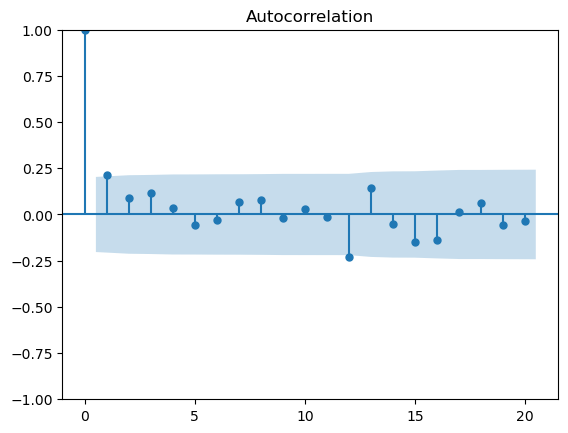

In [541]:
y_diff_12 = df.sales.diff(12).dropna()
y_diff_12.plot();
plot_acf(y_diff_12);

In [542]:
print(f'p value :{adfuller(y_diff_12)[1]}')

p value :2.060579696813685e-11


☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

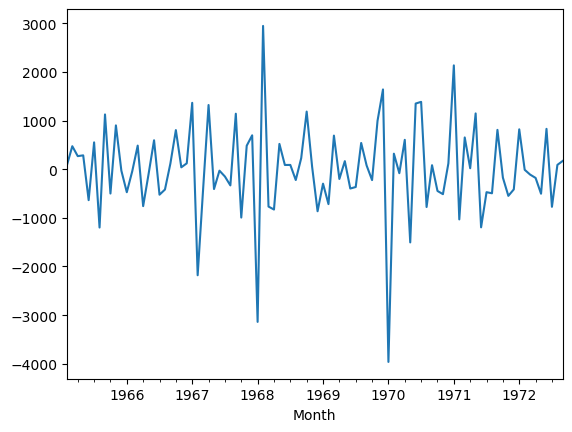

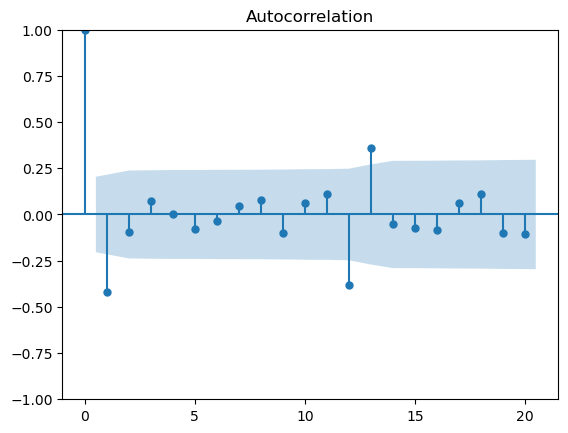

In [543]:
y_diff_12.diff(1).dropna().plot()
plot_acf(y_diff_12.diff(1).dropna());

In [544]:
print(f'p value :{adfuller(y_diff_12.diff(1).dropna())[1]}')
print(f'p value :{adfuller(df.sales.diff(1).diff(1).dropna())[1]}')

p value :0.00026504628492934114
p value :3.643434776649622e-12


👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


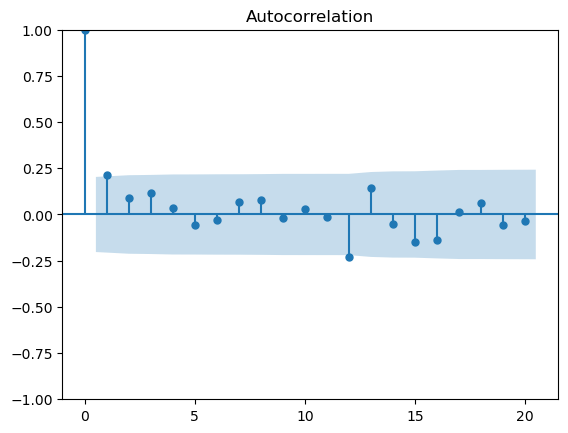

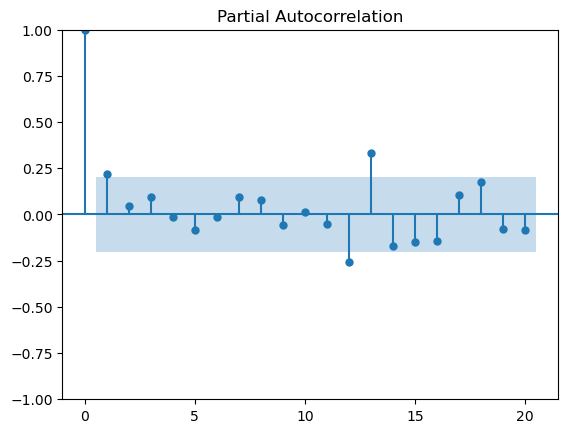

In [545]:

plot_acf(y_diff_12);
plot_pacf(y_diff_12);

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [546]:
model = pm.auto_arima(df_train, start_p=0, d=0, start_q=0, max_p=0, max_q=0, start_P=0, D=1, start_Q=0, max_P=1, max_Q=1, m=12) 

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [547]:
n_periods = len(df_test)
fc, indc =model.predict(n_periods=n_periods, return_conf_int=True)
forecast = pd.Series(fc, index=df_test.index)
central = forecast
upper = pd.Series(indc[:, 1], index=df_test.index)
lower = pd.Series(indc[:, 0], index=df_test.index)

👇 Run the cell below to plot your predictions against reality

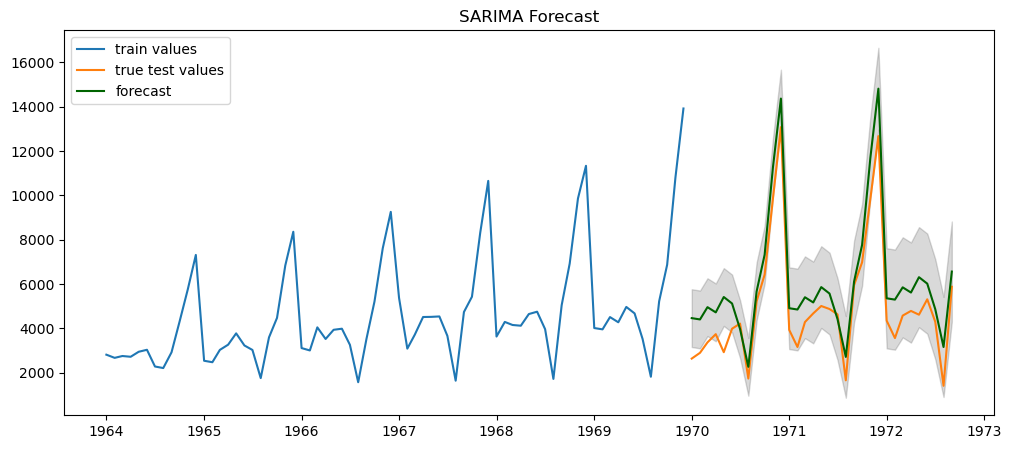

In [548]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

# Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [549]:
# Add lagged values
for i in range(1,13):
    df[f'shifted{i}']= df['sales'].shift(periods=i)

# Drop nan
df = df.dropna()
#create df_train and df_test 
df_train = df.loc[:'1969-12']
df_test = df.loc['1970':]

In [550]:
# Keep track of test_indexes
test_indexes = df.loc['1970':].reset_index().index +1
test_indexes 

RangeIndex(start=1, stop=34, step=1)

In [551]:
# Create X, y
X_train = df_train.reset_index()
X_train.drop(X_train.columns[[0, 1]], axis=1, inplace=True)
y_train = df_train.sales
X_test = df_test.reset_index()
X_test.drop(X_test.columns[[0, 1]], axis=1, inplace=True)
y_test = df_test.sales

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

In [552]:
clf = RandomForestRegressor(max_depth=2, random_state=0)

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [553]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [554]:
results = evaluate_performance_month_prediction(y_train, test_indexes=test_indexes,
                                                         predictor=clf, full_X = X_train)
print(results)

([2475, 3031, 3266, 3776, 3230, 3028, 1759, 3595, 4474, 6838, 8357, 3113, 3006, 4047, 3523, 3937, 3986, 3260, 1573, 3528, 5211, 7614, 9254, 5375, 3088, 3718, 4514, 4520, 4539, 3663, 1643, 4739, 5428], [2541.0, 2502.72, 2734.82, 2824.84, 3062.215, 2968.8975000000005, 3017.5930000000003, 2944.6138333333324, 3393.929333333334, 3698.9497142857144, 4420.688011904761, 3776.8573531746033, 2927.506277777779, 3398.6570844155854, 3780.9513686868686, 3691.901110556112, 3662.5937491674995, 3376.6308132700638, 3315.0115093795093, 3560.818891438626, 3779.279019422486, 6462.358904918179, 7429.028456043956, 3755.2773108640167, 3213.191532706287, 3984.3909729808383, 3912.1122094529997, 4054.3500427798444, 4133.846545284141, 3999.877422491918, 3247.8304618714033, 4064.9838909801106, 6108.72975671703], 0.2188582065585945)


In [555]:
print('Mean Absolute Prediction Error MAPE')
results[2]

Mean Absolute Prediction Error MAPE


0.2188582065585945

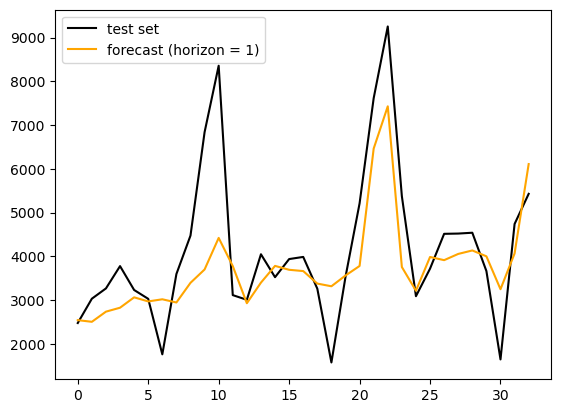

In [556]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [557]:
# Extract the trend using a well chosen moving average

In [558]:
df = pd.read_csv('data/monthly_champagne_sales.csv')
df = df.rename(columns={'Month,"Sales"': "sales"})
df.index = pd.to_datetime(df.index)
df.index.names = ['Month']
df.head()


,sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [559]:
df['rolling_12'] = df['sales'].rolling(12).mean()
df['rolling_3'] = df['sales'].rolling(3).mean()
df['rolling_2'] = df['sales'].rolling(2).mean()
df

,sales,rolling_12,rolling_3,rolling_2
Month,,,,
1964-01-01,2815,NaN,NaN,NaN
1964-02-01,2672,NaN,NaN,2743.5
1964-03-01,2755,NaN,2747.333333,2713.5
1964-04-01,2721,NaN,2716.000000,2738.0
1964-05-01,2946,NaN,2807.333333,2833.5
...,...,...,...,...
1972-05-01,4618,5709.500000,4661.000000,4703.0
1972-06-01,5312,5746.000000,4906.000000,4965.0
1972-07-01,4298,5718.083333,4742.666667,4805.0


<Axes: xlabel='Month'>

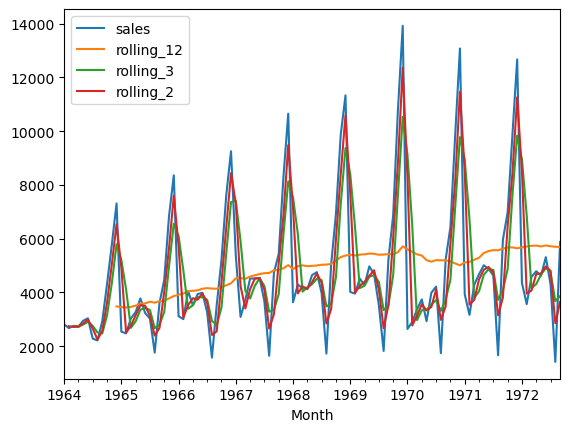

In [560]:
df.plot()

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

In [561]:
df['ewm_12'] = df['sales'].ewm(12).mean()
df['ewm_3'] = df['sales'].ewm(3).mean()
df['ewm_2'] = df['sales'].ewm(2).mean()
df

,sales,rolling_12,rolling_3,rolling_2,ewm_12,ewm_3,ewm_2
Month,,,,,,,
1964-01-01,2815,NaN,NaN,NaN,2815.000000,2815.000000,2815.000000
1964-02-01,2672,NaN,NaN,2743.5,2740.640000,2733.285714,2729.200000
1964-03-01,2755,NaN,2747.333333,2713.5,2745.814499,2742.675676,2741.421053
1964-04-01,2721,NaN,2716.000000,2738.0,2738.847412,2734.748571,2732.938462
1964-05-01,2946,NaN,2807.333333,2833.5,2787.160631,2803.993598,2814.729858
...,...,...,...,...,...,...,...
1972-05-01,4618,5709.500000,4661.000000,4703.0,5544.087030,5300.410710,5076.644417
1972-06-01,5312,5746.000000,4906.000000,4965.0,5526.229099,5303.308033,5155.096278
1972-07-01,4298,5718.083333,4742.666667,4805.0,5431.725109,5051.981024,4869.397519


<Axes: xlabel='Month'>

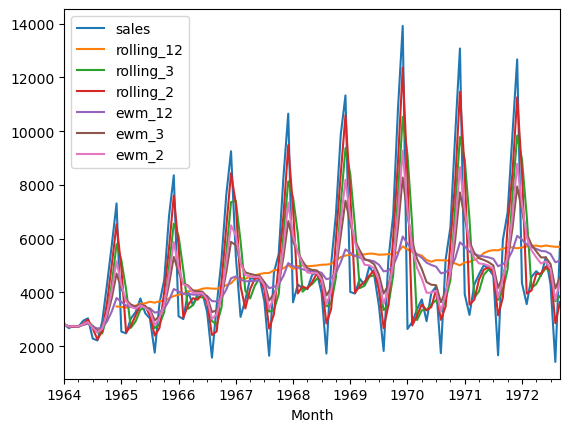

In [562]:
df.plot()

In [563]:
# Drop nan
df = df.dropna()
#create df_train and df_test 
df_train = df.loc[:'1969-12']
df_test = df.loc['1970':]

In [564]:
# Keep track of test_indexes
test_indexes = df.loc['1970':].reset_index().index +1
test_indexes 

RangeIndex(start=1, stop=34, step=1)

In [565]:
# Create X, y
X_train = df_train.reset_index()
X_train.drop(X_train.columns[[0, 1]], axis=1, inplace=True)
y_train = df_train.sales
X_test = df_test.reset_index()
X_test.drop(X_test.columns[[0, 1]], axis=1, inplace=True)
y_test = df_test.sales

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

You should see a better MAPE!

In [566]:
results = evaluate_performance_month_prediction(y_train, test_indexes=test_indexes,
                                                         predictor=clf, full_X = X_train)
print(results)

([2541, 2475, 3031, 3266, 3776, 3230, 3028, 1759, 3595, 4474, 6838, 8357, 3113, 3006, 4047, 3523, 3937, 3986, 3260, 1573, 3528, 5211, 7614, 9254, 5375, 3088, 3718, 4514, 4520, 4539, 3663, 1643, 4739], [7312.0, 3590.62, 2788.98, 3295.01, 3246.618333333334, 3472.916666666667, 3348.7129999999997, 3192.184833333333, 2753.3570714285706, 3283.855583333333, 4370.724214285715, 6927.94, 7424.189, 4474.844619047618, 3825.0356028693523, 3710.3724477466976, 3587.2278835331335, 3718.083715978467, 3756.899464063714, 3145.996522531389, 2688.545843990976, 3594.142668001117, 5988.552122509801, 7223.235928571428, 8048.687262820513, 5913.445347902656, 3908.5672270027444, 3718.893093086372, 3971.256172709105, 4004.131196857339, 3985.7083026768546, 3720.6050556646805, 3457.8268545551364], 0.3744950482344458)


In [567]:
print('Mean Absolute Prediction Error MAPE')
results[2]

Mean Absolute Prediction Error MAPE


0.3744950482344458

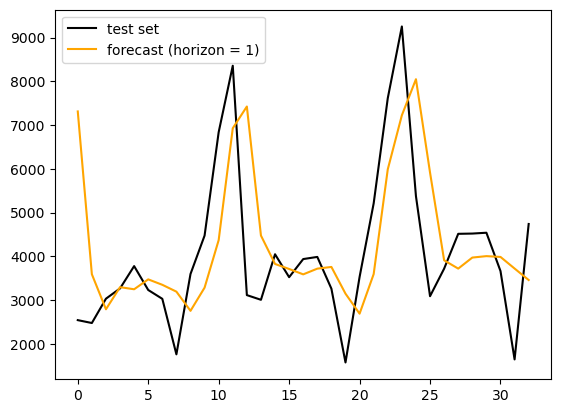

In [568]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

Try to look at the importance of each feature. What do you find?


In [573]:
clf_fit = clf.fit(X_train, y_train)

In [577]:
importances = clf_fit.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(6):
    print("%d. feature %d (%f)" % (f, indices[f], importances[indices[f]]))

Feature ranking:
0. feature 2 (0.877255)
1. feature 5 (0.067610)
2. feature 1 (0.021647)
3. feature 4 (0.020451)
4. feature 0 (0.006632)
5. feature 3 (0.006404)


Rolling_2 (window=2) is the most important feature follow by ewm_2 (halflife=2).

### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA